## Setup

In [1]:
# set libraries to refresh
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import geopandas as gpd

In [5]:
from clustering.kmeans import custom_kmeans, get_oversized_clusters, run_optuna_kmeans_study, parallel_kmeans_secondpass

## Load data

In [6]:
ROOT_DIR = Path("..")
DATA_DIR = ROOT_DIR / "data_hpls"
RAW_DATA_DIR = DATA_DIR / "HPLS R3 Sampling"
INPUT_DATA_DIR = DATA_DIR / "01_modelinputs"
OUTPUT_DATA_DIR = DATA_DIR / "02_modeloutputs"

In [8]:
barangay_grids = gpd.read_parquet("../data/input/data.parquet")  # "PSGC"==200902010

## Clustering

In [9]:
id_col="grid_id"
lat_col="Lat"
lon_col="Lon"
weight_col="population"

In [10]:
# general
epsg = 3121

# first pass
firstpass_weight = 240
firstpass_factor = 1

firstpass_n_jobs = 2
firstpass_n_trials = 96 #8 * firstpass_n_jobs  # can also set to static 96

# second pass
secondpass_cutoff_weight = 300
secondpass_weight = firstpass_weight
secondpass_factor = firstpass_factor

secondpass_python_n_jobs = 1
secondpass_optuna_n_jobs = 2
secondpass_n_trials = 24 #2 * (
#     secondpass_python_n_jobs * secondpass_optuna_n_jobs
# )  #  can also set this to static 24

In [11]:
# select parameters
if barangay_grids["urban"].iloc[0]:
    firstpass_radius = 1000
    secondpass_radius = firstpass_radius
else:
    firstpass_radius = 2000
    secondpass_radius = firstpass_radius
print(f"Grids in barangay: {len(barangay_grids)}")

# first pass
study_firstpass = run_optuna_kmeans_study(
    gdf=barangay_grids,
    desired_cluster_weight=firstpass_weight,
    desired_cluster_radius=firstpass_radius,
    id_col=id_col,
    lat_col=lat_col,
    lon_col=lon_col,
    weight_col=weight_col,
    weight_importance_factor=firstpass_factor,
    epsg=epsg,
    n_trials=firstpass_n_trials,
    n_jobs=firstpass_n_jobs,
    show_progress_bar=True,
)

# proper run with the best n_cluster
clusters = custom_kmeans(
    df=barangay_grids,
    n_clusters=study_firstpass.best_params["n_clusters"],
    id_col=id_col,
    lat_col=lat_col,
    lon_col=lon_col,
    weight_col=weight_col,
)
gdf_w_clusters = barangay_grids.merge(clusters, on=id_col)
gdf_w_clusters = gdf_w_clusters.sort_values(by="cluster_id")

# second pass
oversized_cluster_ids = get_oversized_clusters(
    gdf_w_clusters=gdf_w_clusters, cutoff_weight=secondpass_cutoff_weight
)
n_oversized = len(oversized_cluster_ids)
print(f"Oversized clusters: {n_oversized}")

# add urban_guess column
gdf_w_clusters = gdf_w_clusters.copy()
gdf_w_clusters.loc[:, "dense_area_guess"] = 0
gdf_w_clusters.loc[
    gdf_w_clusters["cluster_weight"] > secondpass_cutoff_weight, "dense_area_guess"
] = 1

# run re-clustering
gdf_w_clusters_doublepass = parallel_kmeans_secondpass(
    gdf_w_clusters=gdf_w_clusters,
    oversized_cluster_ids=oversized_cluster_ids,
    desired_cluster_weight=secondpass_weight,
    desired_cluster_radius=secondpass_radius,
    id_col=id_col,
    lat_col=lat_col,
    lon_col=lon_col,
    weight_col=weight_col,
    weight_importance_factor=secondpass_factor,
    epsg=epsg,
    n_trials=secondpass_n_trials,
    python_n_jobs=secondpass_python_n_jobs,
    optuna_n_jobs=secondpass_optuna_n_jobs,
)
gdf_w_clusters_doublepass = gdf_w_clusters_doublepass.sort_values(by="cluster_id")

Grids in barangay: 1984


  0%|          | 0/96 [00:00<?, ?it/s]

Oversized clusters: 1


<Axes: >

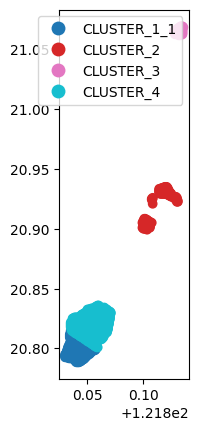

In [13]:
gdf_w_clusters_doublepass.plot(column="cluster_id", legend=True)